/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0020 - val_loss: 8.3537e-04 - learning_rate: 5.0000e-04
Epoch 2/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1752e-04 - val_loss: 2.1635e-04 - learning_rate: 5.0000e-04
Epoch 3/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7140e-04 - val_loss: 7.6259e-05 - learning_rate: 5.0000e-04
Epoch 4/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.1015e-04 - val_loss: 1.1392e-04 - learning_rate: 5.0000e-04
Epoch 5/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.6925e-05 - val_loss: 5.1208e-05 - learning_rate: 5.0000e-04
Epoch 6/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.9721e-05 - val_loss: 7.3258e-05 - learning_rate: 5.0000e-04
Epoch 7/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9315e-05 - val_loss: 8.4430e-05 - learning_rate: 5.0000e-04
Epoch 8/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0086e-05 - val_loss: 6.4239e-05 - learning_rate: 5.0000e-04
Epoch 9/70
161/161 ━━━

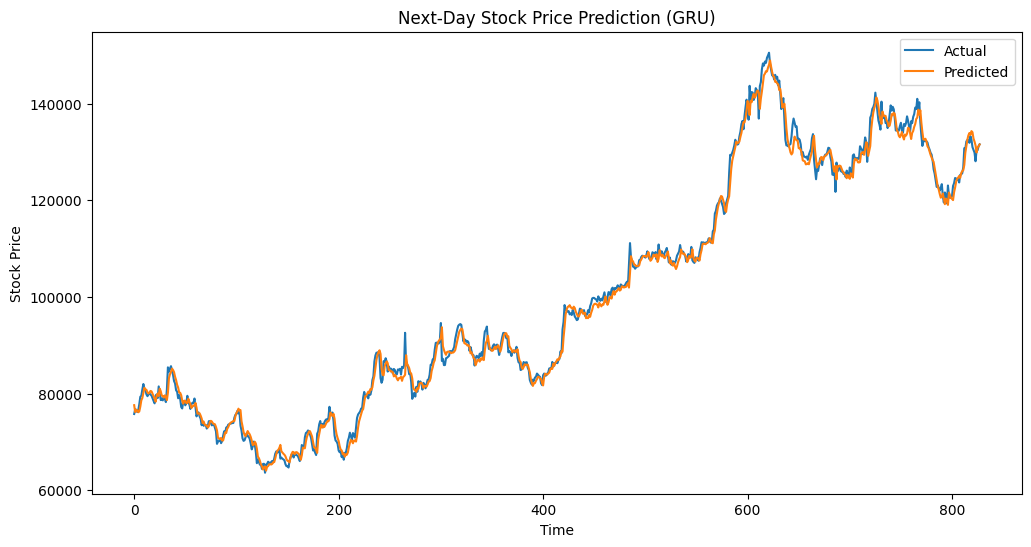

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout,Attention, LayerNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
# import pandas_ta as ta

# Load the dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/MRF.NS_indicators.csv")

# Selecting important features
selected_features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower',"SMA_10","SMA_21"]

# Adding Moving Averages
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()
# data['EMA_5'] = ta.ema(data['close'], length=5)
# data['EMA_8'] = ta.ema(data['close'], length=8)
# data['EMA_13'] = ta.ema(data['close'], length=13)
data = data[selected_features].dropna()


# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences for next-day prediction
def create_sequences(data, sequence_length=20):
    X, y = [], []
    for i in range(len(data) - sequence_length - 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 45
X, y = create_sequences(scaled_data, sequence_length)

# Train-Test-Validation Split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Build GRU Model
model = Sequential()
model.add(Bidirectional(GRU(256, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))))
# model.add(Dropout(0.18))

# model.add(Bidirectional(GRU(512, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile Model
optimizer = AdamW(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0))  # Using Huber Loss

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=24, validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])

# Predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Evaluate Performance
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
r2 = r2_score(y_test_actual, y_pred_actual)
rmse_percentage = (rmse / np.mean(y_test_actual)) * 100

print(f'GRU Next-Day Prediction Metrics:')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')
print(f'RMSE Percentage: {rmse_percentage}%')

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title('Next-Day Stock Price Prediction (GRU)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
import json
import joblib
from tensorflow.keras.models import load_model

# Save Model
model.save('GRU_model.h5')

# Save Scaler
joblib.dump(scaler, 'scaler.pkl')

# Save Features List
features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', "SMA_10", "SMA_21"]
with open('features.json', 'w') as f:
    json.dump(features, f)

# Save Training History
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# Save Performance Metrics
metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape,
    "RMSE_Percentage": rmse_percentage
}
with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f)

with open('sequence_length.txt','w') as f:
  json.dump(sequence_length,f)


In [ ]:
import json
import joblib
from tensorflow.keras.models import load_model

# Load Model
model = load_model('GRU_model.h5')

# Load Scaler
scaler = joblib.load('scaler.pkl')

# Load Features List
with open('features.json', 'r') as f:
    features = json.load(f)

# Load Training History
with open('training_history.json', 'r') as f:
    history_data = json.load(f)

# Load Performance Metrics
with open('model_metrics.json', 'r') as f:
    metrics = json.load(f)


with open('sequence_length.txt', 'r') as f:
    sequence = int(f.read().strip())  # Read, strip whitespace, and convert to integer

import pandas as pd
import numpy as np
# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/TCS.NS_indicators.csv")


# Select relevant features (same as training)
selected_features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', "SMA_10", "SMA_21"]

data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()



# Normalize the data using the previously saved scaler
scaled_data = scaler.transform(data[selected_features])

# Extract the last `sequence_length` rows for prediction
sequence_length = 45   # Same as training
X_latest = np.array([scaled_data[-sequence_length:]])  # Shape (1, sequence_length, num_features)

# Predict next-day close price
y_pred = model.predict(X_latest)

# Reshape prediction to match scaler's expected input shape
y_pred_rescaled = np.zeros((1, scaled_data.shape[1]))  # Create zero-filled array
y_pred_rescaled[:, 0] = y_pred[:, 0]  # Assign predicted close price to first column

# Inverse transform only the close price
y_pred_actual = scaler.inverse_transform(y_pred_rescaled)[:, 0]

print(f'Predicted Next-Day Close Price: {y_pred_actual[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Predicted Next-Day Close Price: 5591.8963035802135


In [ ]:
import pandas as pd
import numpy as np
# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/TCS.NS_indicators.csv")


# Select relevant features (same as training)
selected_features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', "SMA_10", "SMA_21"]

data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()



# Normalize the data using the previously saved scaler
scaled_data = scaler.transform(data[selected_features])

# Extract the last `sequence_length` rows for prediction
sequence_length = 45   # Same as training
X_latest = np.array([scaled_data[-sequence_length:]])  # Shape (1, sequence_length, num_features)

# Predict next-day close price
y_pred = model.predict(X_latest)

# Reshape prediction to match scaler's expected input shape
y_pred_rescaled = np.zeros((1, scaled_data.shape[1]))  # Create zero-filled array
y_pred_rescaled[:, 0] = y_pred[:, 0]  # Assign predicted close price to first column

# Inverse transform only the close price
y_pred_actual = scaler.inverse_transform(y_pred_rescaled)[:, 0]

print(f'Predicted Next-Day Close Price: {y_pred_actual[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Next-Day Close Price: 4106.249143020757


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("GRU_model.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 512)                 │         416,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 416,771 (1.59 MB)

 Trainable params: 416,769 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import json
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load Model
model = load_model('GRU_model.h5')

# Load Scaler
scaler = joblib.load('scaler.pkl')

# Load Features List
with open('features.json', 'r') as f:
    features = json.load(f)

# Load Training History
with open('training_history.json', 'r') as f:
    history_data = json.load(f)

# Load Performance Metrics
with open('model_metrics.json', 'r') as f:
    metrics = json.load(f)

# Load Sequence Length
with open('sequence_length.txt', 'r') as f:
    sequence_length = int(f.read().strip())  # Read, strip whitespace, and convert to integer

# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/TCS.NS_indicators.csv")

# Ensure features used are the same as during training
selected_features = features  # Use features.json to maintain consistency

# Compute missing indicators
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()

# Drop NaN values caused by rolling calculations
data.dropna(inplace=True)

# Normalize the data
scaled_data = scaler.transform(data[selected_features])

# Extract the last `sequence_length` rows for prediction
X_latest = np.array([scaled_data[-sequence_length:]])  # Shape (1, sequence_length, num_features)

# Predict next-day close price
y_pred = model.predict(X_latest)

# Prepare for inverse transformation
y_pred_rescaled = scaled_data[-1:].copy()  # Copy last row
y_pred_rescaled[:, 0] = y_pred[:, 0]  # Replace close price with prediction

# Inverse transform to get actual predicted price
y_pred_actual = scaler.inverse_transform(y_pred_rescaled)[:, 0]

print(f'Predicted Next-Day Close Price: {y_pred_actual[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Predicted Next-Day Close Price: 4028.4480281030987


In [ ]:
import json
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load Model
model = load_model('GRU_model.h5')

# Load Scaler
scaler = joblib.load('scaler.pkl')

# Load Features List
with open('features.json', 'r') as f:
    features = json.load(f)

# Load Sequence Length
with open('sequence_length.txt', 'r') as f:
    sequence_length = int(f.read().strip())  # Read sequence length from file

# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/TCS.NS_indicators.csv")

# Select relevant features (use features.json to maintain consistency)
selected_features = features

# Compute missing indicators (same as original code)
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()

# Drop NaN values caused by rolling calculations
data.dropna(inplace=True)

# Normalize the data
scaled_data = scaler.transform(data[selected_features])

# Extract the last `sequence_length` rows for prediction
X_latest = np.array([scaled_data[-sequence_length:]])  # Shape (1, sequence_length, num_features)

# Predict next-day close price
y_pred = model.predict(X_latest)

# Reconstruct the original approach for inverse transformation
y_pred_rescaled = np.zeros_like(scaled_data[-1:])  # Create zero-filled array
y_pred_rescaled[:, 0] = y_pred[:, 0]  # Assign predicted close price to first column

# Inverse transform only the close price
y_pred_actual = scaler.inverse_transform(y_pred_rescaled)[:, 0]

print(f'Predicted Next-Day Close Price: {y_pred_actual[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Predicted Next-Day Close Price: 4028.4480281030987


In [ ]:
print("Features from JSON:", features)
print("Selected Features:", selected_features)


Features from JSON: ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', 'SMA_10', 'SMA_21']
Selected Features: ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', 'SMA_10', 'SMA_21']


In [ ]:
import json
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load Model
model = load_model('GRU_model.h5')

# Load Scaler
scaler = joblib.load('scaler.pkl')

# Load Features List
with open('features.json', 'r') as f:
    features = json.load(f)

# Load Sequence Length
with open('sequence_length.txt', 'r') as f:
    sequence_length = int(f.read().strip())  # Read sequence length from file

# Load dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/MRF.NS_indicators.csv")

# Select relevant features (use features.json to maintain consistency)
selected_features = features

# Compute missing indicators (same as original code)
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_21'] = data['close'].rolling(window=21).mean()

# Drop NaN values caused by rolling calculations
data.dropna(inplace=True)

# Normalize the data
scaled_data = scaler.transform(data[selected_features])

# Extract the last `sequence_length` rows for prediction
X_latest = np.array([scaled_data[-sequence_length:]])  # Shape (1, sequence_length, num_features)

# Predict next-day close price
y_pred = model.predict(X_latest)

# Reconstruct the original approach for inverse transformation
y_pred_rescaled = np.zeros_like(scaled_data[-1:])  # Create zero-filled array
y_pred_rescaled[:, 0] = y_pred[:, 0]  # Assign predicted close price to first column

# Inverse transform only the close price
y_pred_actual = scaler.inverse_transform(y_pred_rescaled)[:, 0][0]
print(y_pred_actual)

# Get the last closing price
last_close = data['close'].iloc[-1]

# Calculate actual 5-day and 10-day percentage changes
if len(data) >= 10:  # Ensure enough data exists
    close_5_days_ago = data['close'].iloc[-6]  # 5 days ago (including current day)
    close_10_days_ago = data['close'].iloc[-11]  # 10 days ago

    change_5_days = ((last_close - close_5_days_ago) / close_5_days_ago) * 100
    change_10_days = ((last_close - close_10_days_ago) / close_10_days_ago) * 100
else:
    change_5_days, change_10_days = None, None  # Not enough data

# Store results in a dictionary
output_data = {
    "predicted_close": str(round(y_pred_actual, 2)),
    "change_5_days": str(round(change_5_days, 2)) if change_5_days is not None else None,
    "change_10_days": str(round(change_10_days, 2)) if change_10_days is not None else None
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
122606.89493419077


In [ ]:
output_data

{'predicted_close': '122606.89',
 'change_5_days': '2.14',
 'change_10_days': '3.33'}

In [ ]:
output_file = f'MRF.NS.json'
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)